https://pytorch-geometric.readthedocs.io/en/latest/tutorial/load_csv.html

In [1]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'

/Users/leo/anaconda3/envs/graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [17]:
import pandas as pd

display(pd.read_csv(movie_path))
display(pd.read_csv(rating_path))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
import torch

def load_node_csv(path, index_col, encoders=None, **kwargs):
    df = pd.read_csv(path, index_col=index_col, **kwargs)
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

In [4]:
from sentence_transformers import SentenceTransformer

class SequenceEncoder:
    def __init__(self, model_name='all-MiniLM-L6-v2', device=None):
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)

    @torch.no_grad()
    def __call__(self, df):
        x = self.model.encode(df.values, show_progress_bar=True,
                              convert_to_tensor=True, device=self.device)
        return x.cpu()

In [5]:
class GenresEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        genres = set(g for col in df.values for g in col.split(self.sep))
        mapping = {genre: i for i, genre in enumerate(genres)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for genre in col.split(self.sep):
                x[i, mapping[genre]] = 1
        return x

In [13]:
movie_x, movie_mapping = load_node_csv(
    movie_path, index_col='movieId', encoders={
        'title': SequenceEncoder(),
        'genres': GenresEncoder()
    })

_, user_mapping = load_node_csv(rating_path, index_col='userId')

/Users/leo/anaconda3/envs/graph/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 305/305 [00:03<00:00, 78.18it/s] 


In [24]:
movie_x.shape, movie_x

(torch.Size([9742, 404]),
 tensor([[-0.0828,  0.0530,  0.0536,  ...,  0.0000,  1.0000,  0.0000],
         [-0.1053,  0.1508, -0.0264,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0988,  0.0177, -0.0527,  ...,  0.0000,  1.0000,  0.0000],
         ...,
         [-0.1115,  0.0310, -0.0177,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0366,  0.0137,  0.0315,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0500, -0.0141, -0.0031,  ...,  0.0000,  1.0000,  0.0000]]))

In [ ]:
len(movie_mapping), movie_mapping

In [ ]:
user_mapping

In [8]:
from torch_geometric.data import HeteroData

data = HeteroData()

data['user'].num_nodes = len(user_mapping)  # Users do not have any features.
data['movie'].x = movie_x

print(data)

HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] }
)


In [9]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
                  encoders=None, **kwargs):
    df = pd.read_csv(path, **kwargs)

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
class IdentityEncoder:
    def __init__(self, dtype=None):
        self.dtype = dtype

    def __call__(self, df):
        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

In [11]:
edge_index, edge_label = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    encoders={'rating': IdentityEncoder(dtype=torch.long)},
)

data['user', 'rates', 'movie'].edge_index = edge_index
data['user', 'rates', 'movie'].edge_label = edge_label

print(data)

HeteroData(
  user={ num_nodes=610 },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 100836],
    edge_label=[100836, 1],
  }
)


/Users/leo/anaconda3/envs/graph/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


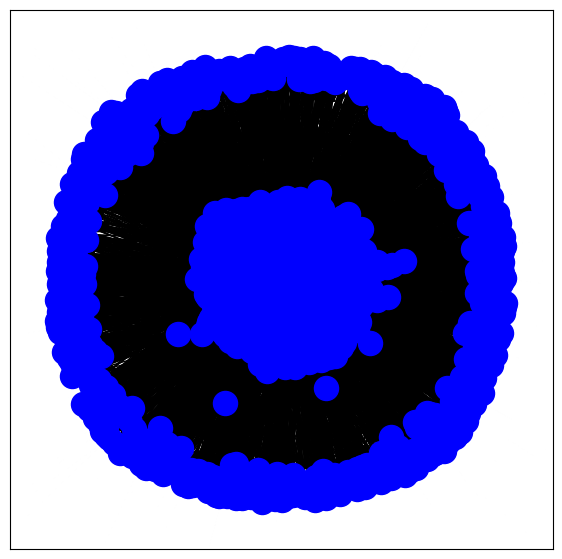

In [34]:
# Long running time: 3m 14.6s
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=False)
visualize_graph(G, color="blue")